In [3]:
# import libraries
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, precision_score, recall_score, f1_score, roc_auc_score

In [4]:
#load the data
data = pd.read_csv('/content/framingham_heart_study.csv')
data.head()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


In [5]:
# Preview all columns
data.columns

Index(['male', 'age', 'education', 'currentSmoker', 'cigsPerDay', 'BPMeds',
       'prevalentStroke', 'prevalentHyp', 'diabetes', 'totChol', 'sysBP',
       'diaBP', 'BMI', 'heartRate', 'glucose', 'TenYearCHD'],
      dtype='object')

In [6]:
# Preview counts of NULL values
data.isnull().sum()

,0
male,0
age,0
education,105
currentSmoker,0
cigsPerDay,29
BPMeds,53
prevalentStroke,0
prevalentHyp,0
diabetes,0
totChol,50


In [7]:
# Preview counts of duplicated records
data.duplicated().sum()

np.int64(0)

In [8]:
# Preview dataset shape; rows: columns
data.shape

(4240, 16)

In [9]:
# Drop records with NULL values
data.dropna(inplace=True)

# Verify that there are no NULL values left
data.isnull().sum()

,0
male,0
age,0
education,0
currentSmoker,0
cigsPerDay,0
BPMeds,0
prevalentStroke,0
prevalentHyp,0
diabetes,0
totChol,0


Data Distribution

/tmp/ipython-input-887923207.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  data.hist(ax = ax)


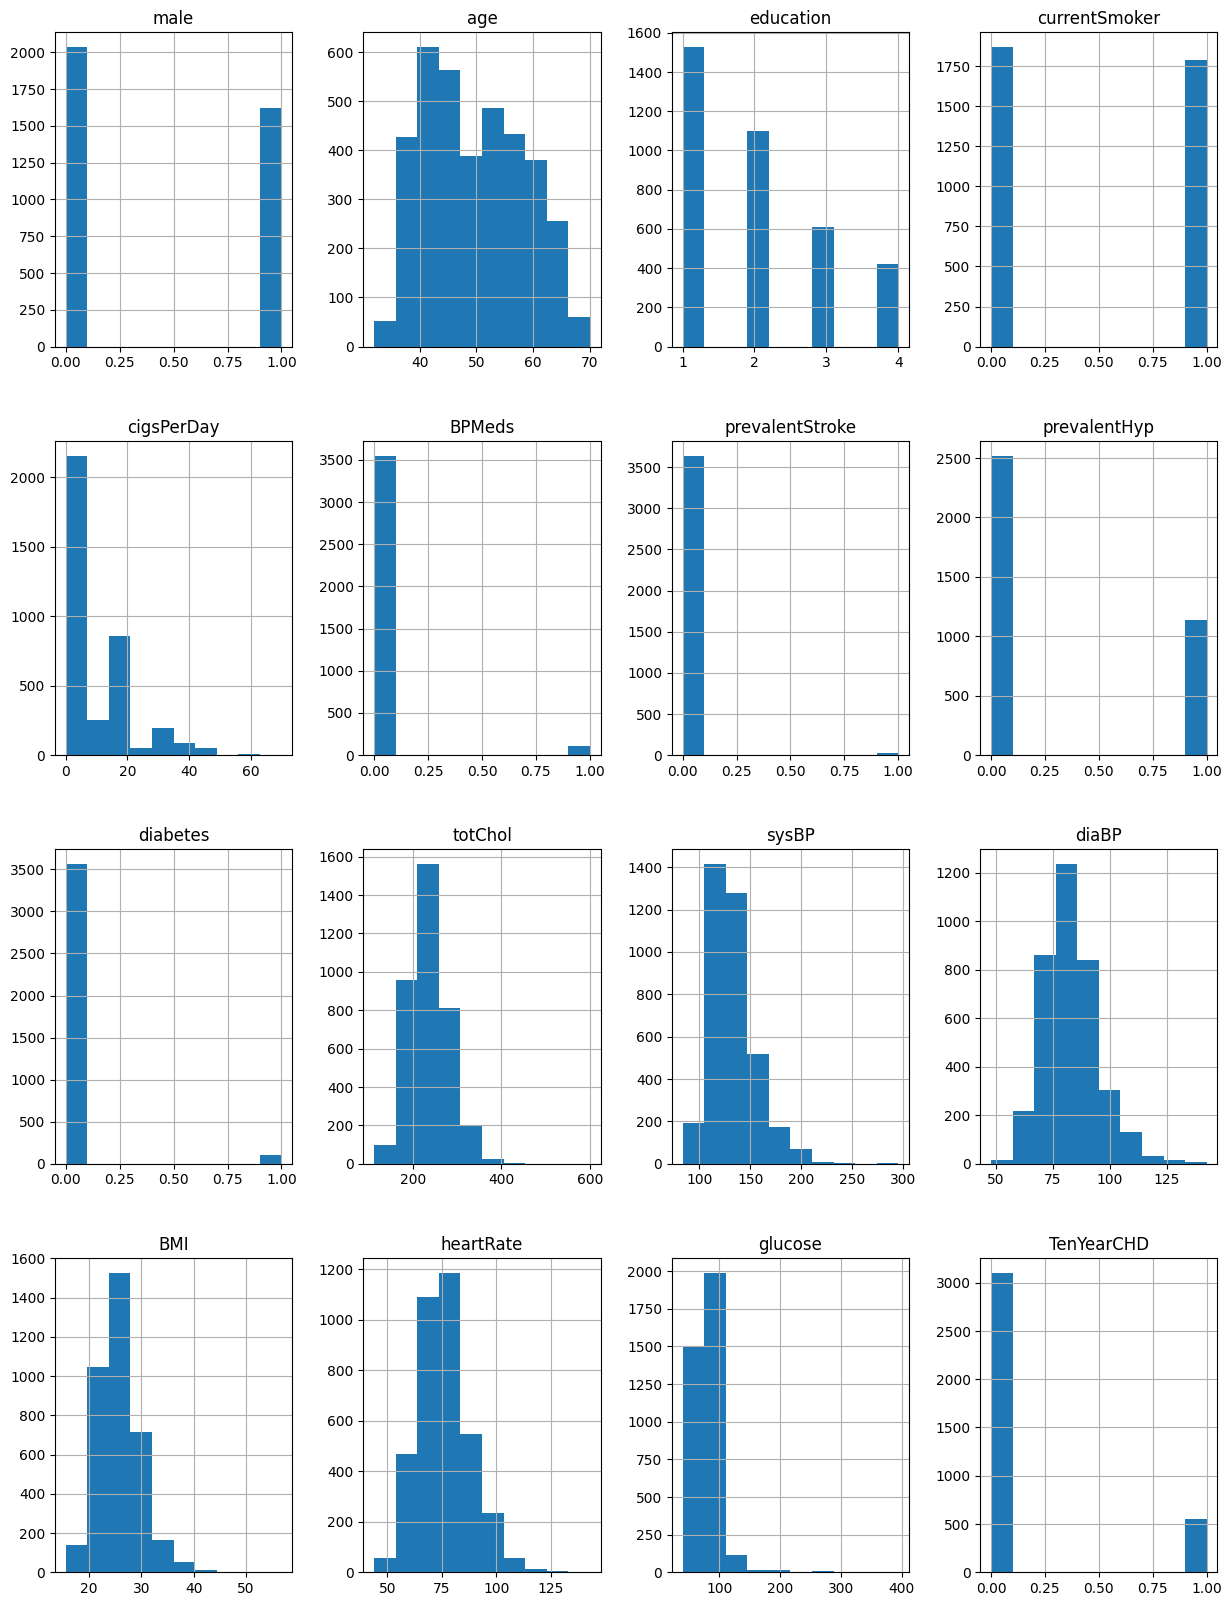

In [10]:
# plot histogram to see the distribution of the data
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
data.hist(ax = ax)
plt.show()

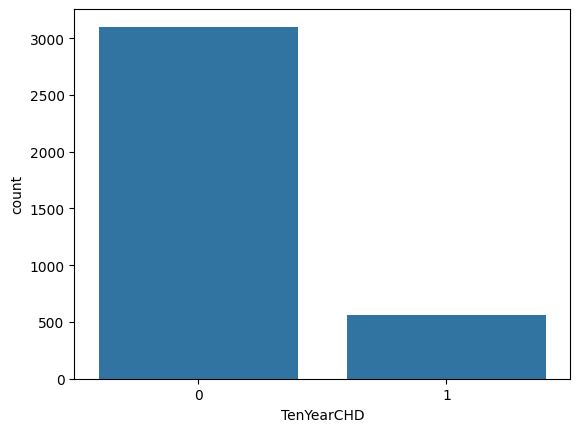

There are 3101 patients without heart disease and 557 patients with the disease


In [11]:
sns.countplot(x='TenYearCHD',data=data)
plt.show()
cases = data.TenYearCHD.value_counts()
print(f"There are {cases[0]} patients without heart disease and {cases[1]} patients with the disease")

The data is not properly balanced as the number of people without the disease greately exceeds the number of people with the disease. The ratio is about 1:5.57

In [12]:
from operator import add

def stacked_barchart(data, title = None, ylabel = None, xlabel = None):
    default_colors = ['#008080', '#5f3c41', '#219AD8']
    # From raw value to percentage
    totals = data.sum(axis=1)
    bars = ((data.T / totals) * 100).T
    r = list(range(data.index.size))

    # Plot
    barWidth = 0.95
    names = data.index.tolist()
    bottom = [0] * bars.shape[0]

    # Create bars
    color_index = 0
    plots = []
    for bar in bars.columns:
        plots.append(plt.bar(r, bars[bar], bottom=bottom, color=default_colors[color_index], edgecolor='white', width=barWidth))
        bottom = list(map(add, bottom, bars[bar]))
        color_index = 0 if color_index >= len(default_colors) else color_index + 1

    # Custom x axis
    plt.title(title)
    plt.xticks(r, names)
    plt.xlabel(data.index.name if xlabel is None else xlabel)
    plt.ylabel(data.columns.name if ylabel is None else ylabel)
    ax = plt.gca()

    y_labels = ax.get_yticks()
    ax.set_yticklabels([str(y) + '%' for y in y_labels])

    flat_list = [item for sublist in data.T.values for item in sublist]
    for i, d in zip(ax.patches, flat_list):
        data_label = str(d) + " (" + str(round(i.get_height(), 2)) + "%)"
        ax.text(i.get_x() + 0.45, i.get_y() + 5, data_label, horizontalalignment='center', verticalalignment='center', fontdict = dict(color = 'white', size = 20))

    for item in ([ax.title]):
        item.set_fontsize(27)

    for item in ([ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(24)

    legend = ax.legend(plots, bars.columns.tolist(), fancybox=True)
    plt.setp(legend.get_texts(), fontsize='20')

/tmp/ipython-input-2869839754.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([str(y) + '%' for y in y_labels])
/tmp/ipython-input-2869839754.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([str(y) + '%' for y in y_labels])
/tmp/ipython-input-2869839754.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([str(y) + '%' for y in y_labels])
/tmp/ipython-input-2869839754.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([str(y) + '%' for y in y_labels])
/tmp/ipython-input-2869839754.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e

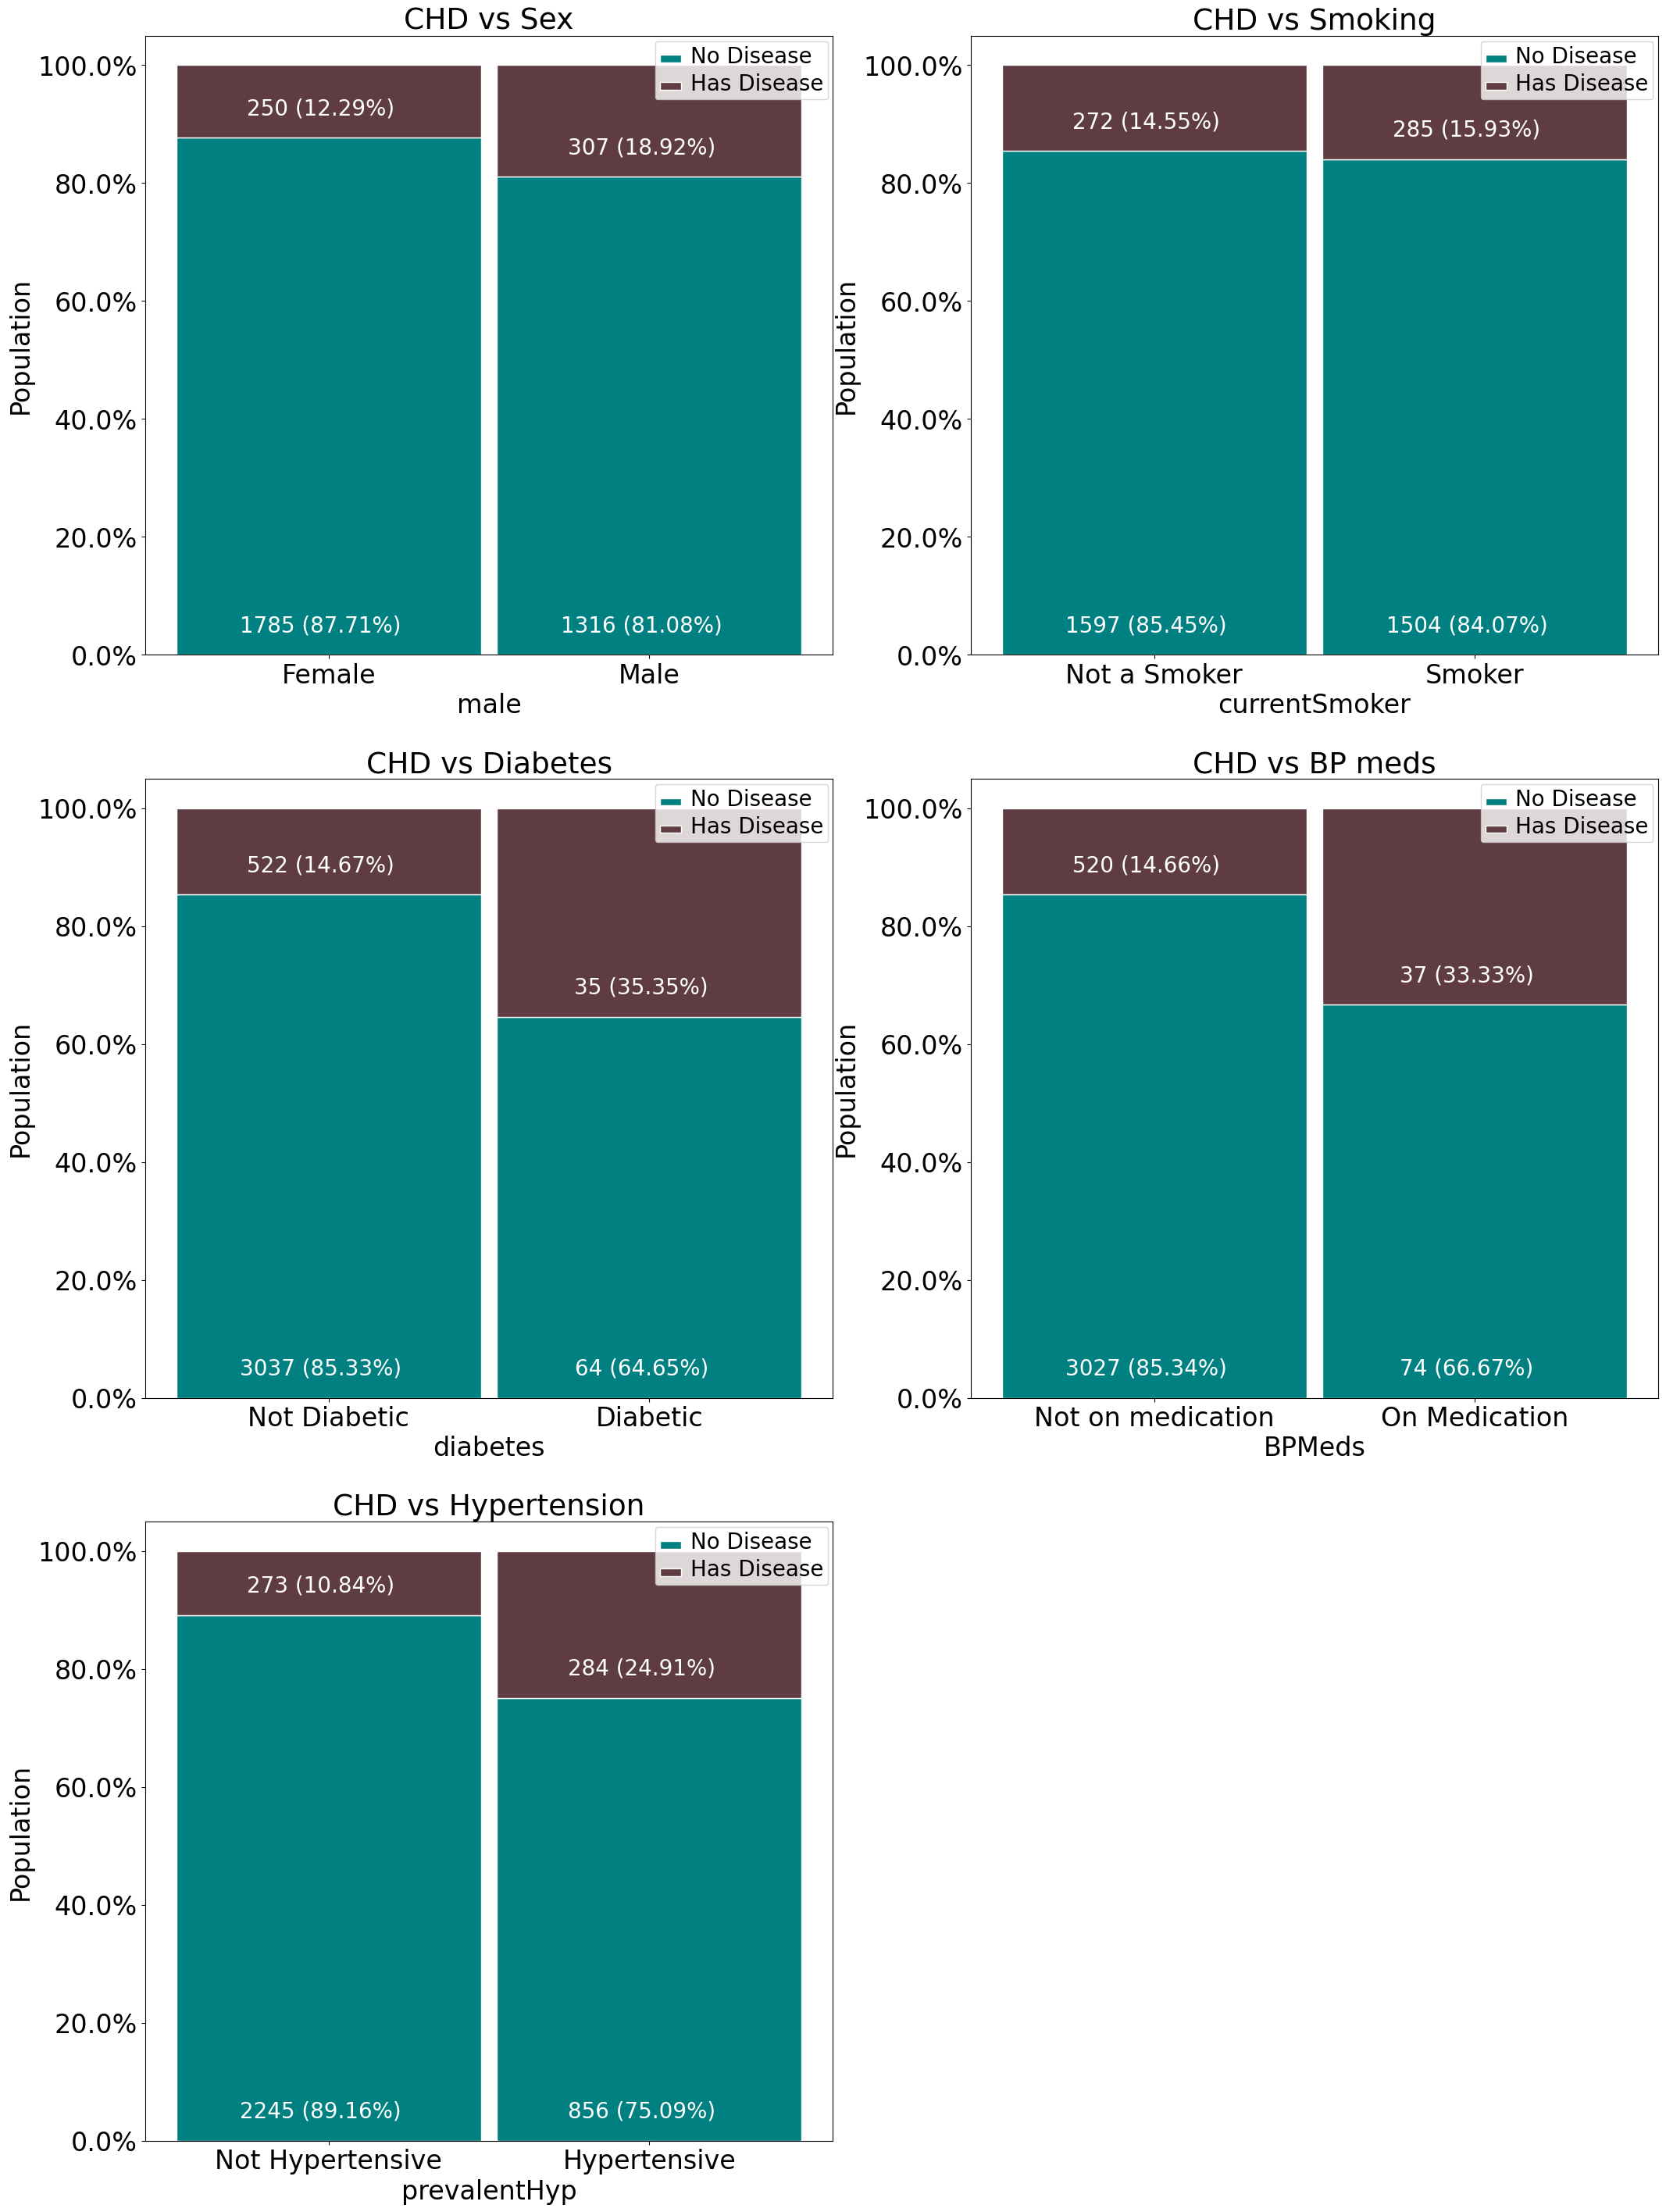

In [13]:
fig = plt.gcf()
fig.set_size_inches(25, 35)
grid_rows = 3
grid_cols = 2

#draw sex vs disease outcome
plt.subplot(grid_rows, grid_cols, 1)
temp = data[['male','TenYearCHD']].groupby(['male','TenYearCHD']).size().unstack('TenYearCHD')
temp.rename(index={0:'Female', 1:'Male'}, columns={0:'No Disease', 1:'Has Disease'}, inplace = True)
stacked_barchart(temp, title = 'CHD vs Sex', ylabel = 'Population')

#draw smoking satus vs disease outcome
plt.subplot(grid_rows, grid_cols, 2)
temp = data[['currentSmoker','TenYearCHD']].groupby(['currentSmoker','TenYearCHD']).size().unstack('TenYearCHD')
temp.rename(index={0:'Not a Smoker', 1:'Smoker'}, columns={0:'No Disease', 1:'Has Disease'}, inplace = True)
stacked_barchart(temp, title = 'CHD vs Smoking', ylabel = 'Population')

#draw diabetes vs disease outcome
plt.subplot(grid_rows, grid_cols, 3)
temp = data[['diabetes','TenYearCHD']].groupby(['diabetes','TenYearCHD']).size().unstack('TenYearCHD')
temp.rename(index={0:'Not Diabetic', 1:'Diabetic'}, columns={0:'No Disease', 1:'Has Disease'}, inplace = True)
stacked_barchart(temp, title = 'CHD vs Diabetes', ylabel = 'Population')

#draw BP meds vs disease outcome
plt.subplot(grid_rows, grid_cols, 4)
temp = data[['BPMeds','TenYearCHD']].groupby(['BPMeds','TenYearCHD']).size().unstack('TenYearCHD')
temp.rename(index={0:'Not on medication', 1:'On Medication'}, columns={0:'No Disease', 1:'Has Disease'}, inplace = True)
stacked_barchart(temp, title = 'CHD vs BP meds', ylabel = 'Population')

#draw Hypertension vs disease outcome
plt.subplot(grid_rows, grid_cols, 5)
temp = data[['prevalentHyp','TenYearCHD']].groupby(['prevalentHyp','TenYearCHD']).size().unstack('TenYearCHD')
temp.rename(index={0:'Not Hypertensive', 1:'Hypertensive'}, columns={0:'No Disease', 1:'Has Disease'}, inplace = True)
stacked_barchart(temp, title = 'CHD vs Hypertension', ylabel = 'Population')

Due to the imbalanced nature of the dataset it is difficult to make conclusions but based on what is observed but these are the conclusions that can be drawn:

Slightly more males are suffering from CHD than females
The percentage of people who have CHD is almost equal between smokers and non smokers
The percentage of people who have CHD is higher among the diabetic, and those with prevalent hypertesion as compared to those who dont have similar morbidities
A larger percentage of the people who have CHD are on blood pressure medication

 ## Number of people who have disease vs age

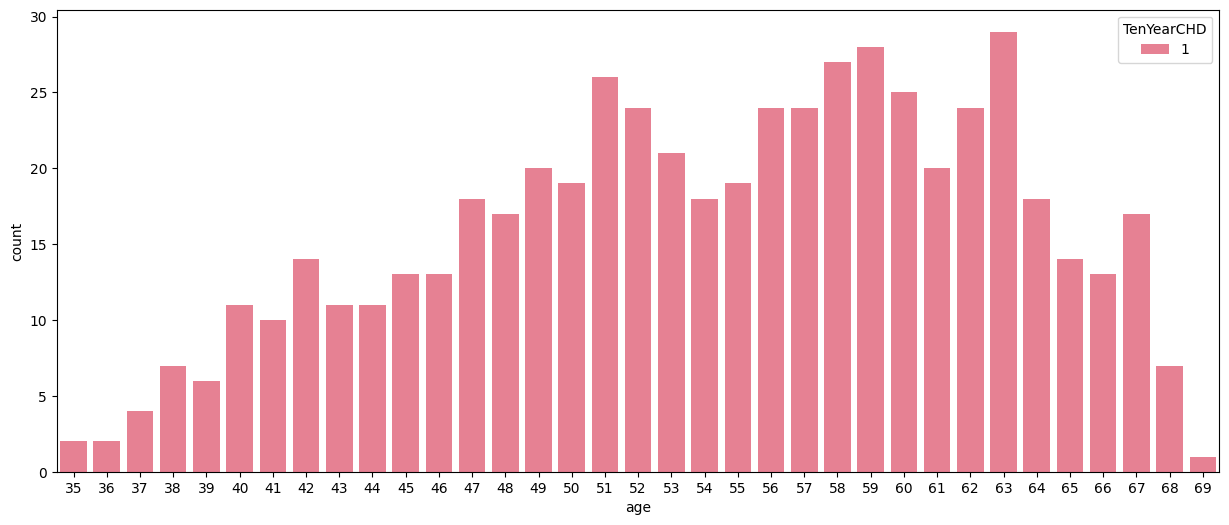

In [14]:
positive_cases = data[data['TenYearCHD'] == 1]
plt.figure(figsize=(15,6))
sns.countplot(x='age',data = positive_cases, hue = 'TenYearCHD', palette='husl')
plt.show()

The people with the highest risk of developing CHD are betwwen the ages of 51 and 63

The number of sick people generally increases with age

## Correlation Heat map

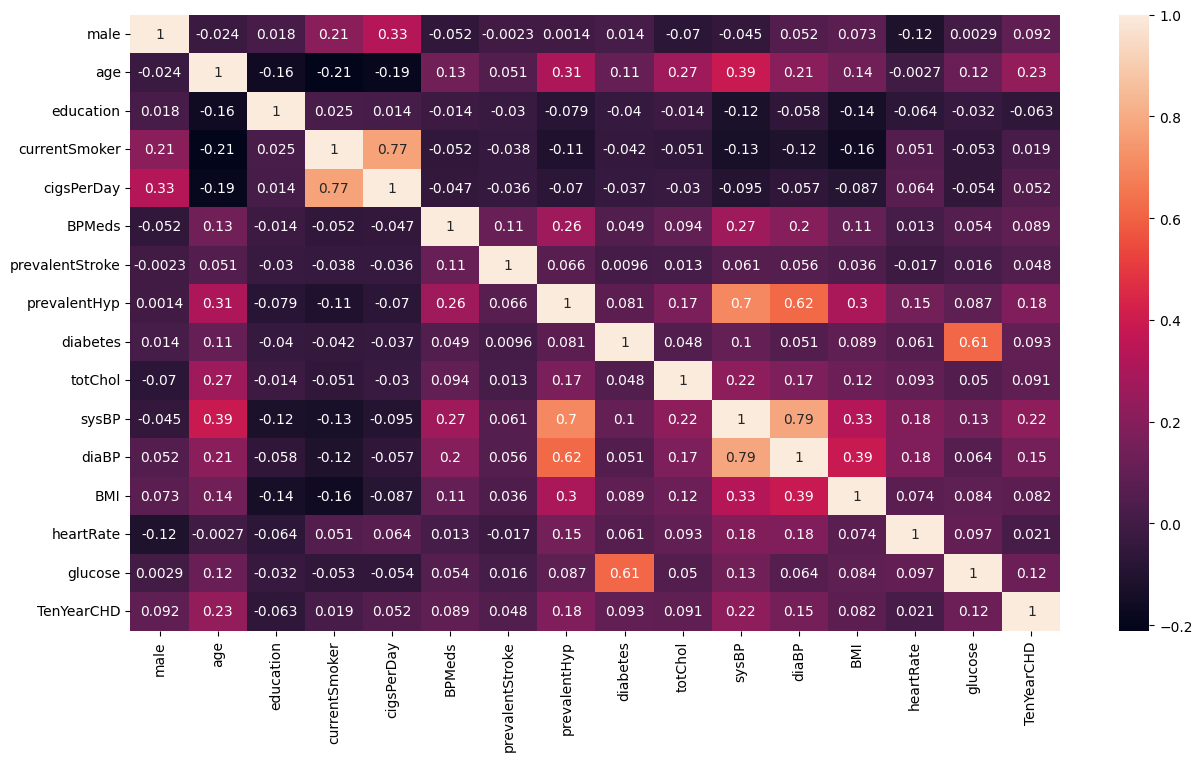

In [15]:
plt.figure(figsize=(15,8))
sns.heatmap(data.corr(), annot = True)
plt.show()

## Feature Selection

In [16]:
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy

In [17]:
!pip install boruta

In [18]:
#define the features
X = data.iloc[:,:-1].values
y = data.iloc[:,-1].values

forest = RandomForestClassifier(n_estimators=1000, n_jobs=-1, class_weight='balanced')

# define Boruta feature selection method
feat_selector = BorutaPy(forest, n_estimators='auto', verbose=2)

# find all relevant features
feat_selector.fit(X, y)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	15
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	15
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	15
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	15
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	15
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	15
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	15
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	2
Tentative: 	4
Rejected: 	9
Iteration: 	9 / 100
Confirmed: 	2
Tentative: 	4
Rejected: 	9
Iteration: 	10 / 100
Confirmed: 	2
Tentative: 	4
Rejected: 	9
Iteration: 	11 / 100
Confirmed: 	2
Tentative: 	4
Rejected: 	9
Iteration: 	12 / 100
Confirmed: 	2
Tentative: 	4
Rejected: 	9
Iteration: 	13 / 100
Confirmed: 	2
Tentative: 	4
Rejected: 	9
Iteration: 	14 / 100
Confirmed: 	2
Tentative: 	4
Rejected: 	9
Iteration: 	15 / 100
Confirmed: 	2
Tentative: 	4
Rejected: 	9
Iteration: 	16 / 100
Confirmed: 	2
Tentative: 	4
Rejected: 	9
Iteration:

BorutaPy(estimator=RandomForestClassifier(class_weight='balanced',
                                          n_estimators=31, n_jobs=-1,
                                          random_state=RandomState(MT19937) at 0x7FD07CA80A40),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x7FD07CA80A40, verbose=2)

In [19]:
# show the most important features
most_important = data.columns[:-1][feat_selector.support_].tolist()
most_important

['age', 'sysBP']

In [20]:
# select the top 6 features
top_features = data.columns[:-1][feat_selector.ranking_ <=6].tolist()
top_features

['age',
 'cigsPerDay',
 'totChol',
 'sysBP',
 'diaBP',
 'BMI',
 'heartRate',
 'glucose']

In [21]:
import statsmodels.api as sm
X_top = data[top_features]
y = data['TenYearCHD']
res = sm.Logit(y,X_top).fit()
res.summary()

Optimization terminated successfully.
         Current function value: 0.413285
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             TenYearCHD   No. Observations:                 3658
Model:                          Logit   Df Residuals:                     3650
Method:                           MLE   Df Model:                            7
Date:                Tue, 28 Oct 2025   Pseudo R-squ.:                 0.03127
Time:                        16:41:15   Log-Likelihood:                -1511.8
converged:                       True   LL-Null:                       -1560.6
Covariance Type:            nonrobust   LLR p-value:                 3.388e-18
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
age            0.0259      0.006      4.516      0.000       0.015       0.037
cigsPerDay     0.0160      0.004      4.190      0.000       0.009       0.023
totChol       -0.0032      0.001     -2.907      0.004      -0.005      -0.001
sysBP          0.0262      0.003      7.761      0.000       0.020       0.033
diaBP         -0.0290      0.006     -4.838      0.000      -0.041      -0.017
BMI           -0.0517      0.012     -4.244      0.000      -0.076      -0.028
heartRate     -0.0333      0.004     -8.624      0.000      -0.041      -0.026
glucose        0.0041      0.002      2.470      0.014       0.001       0.007
==============================================================================
"""

In [22]:
params = res.params
conf = res.conf_int()
conf['Odds Ratio'] = params
conf.columns = ['5%', '95%', 'Odds Ratio']
print(np.exp(conf))

                  5%       95%  Odds Ratio
age         1.014747  1.037785    1.026201
cigsPerDay  1.008552  1.023761    1.016128
totChol     0.994635  0.998953    0.996792
sysBP       1.019746  1.033309    1.026505
diaBP       0.960121  0.982919    0.971453
BMI         0.927144  0.972538    0.949569
heartRate   0.959992  0.974620    0.967278
glucose     1.000848  1.007388    1.004113


/usr/local/lib/python3.12/dist-packages/seaborn/axisgrid.py:1513: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  func(x=vector, **plot_kwargs)
/usr/local/lib/python3.12/dist-packages/seaborn/axisgrid.py:1513: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  func(x=vector, **plot_kwargs)
/usr/local/lib/python3.12/dist-packages/seaborn/axisgrid.py:1513: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  func(x=vector, **plot_kwargs)
/usr/local/lib/python3.12/dist-packages/seaborn/axisgrid.py:1513: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  func(x=vector, **plot_kwargs)
/usr/local/lib/python3.12/dist-packages/seaborn/axisgrid.py:1513: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  func(x=vector, **plot_kwargs)
/usr/local/lib/python3.12/dist-pack

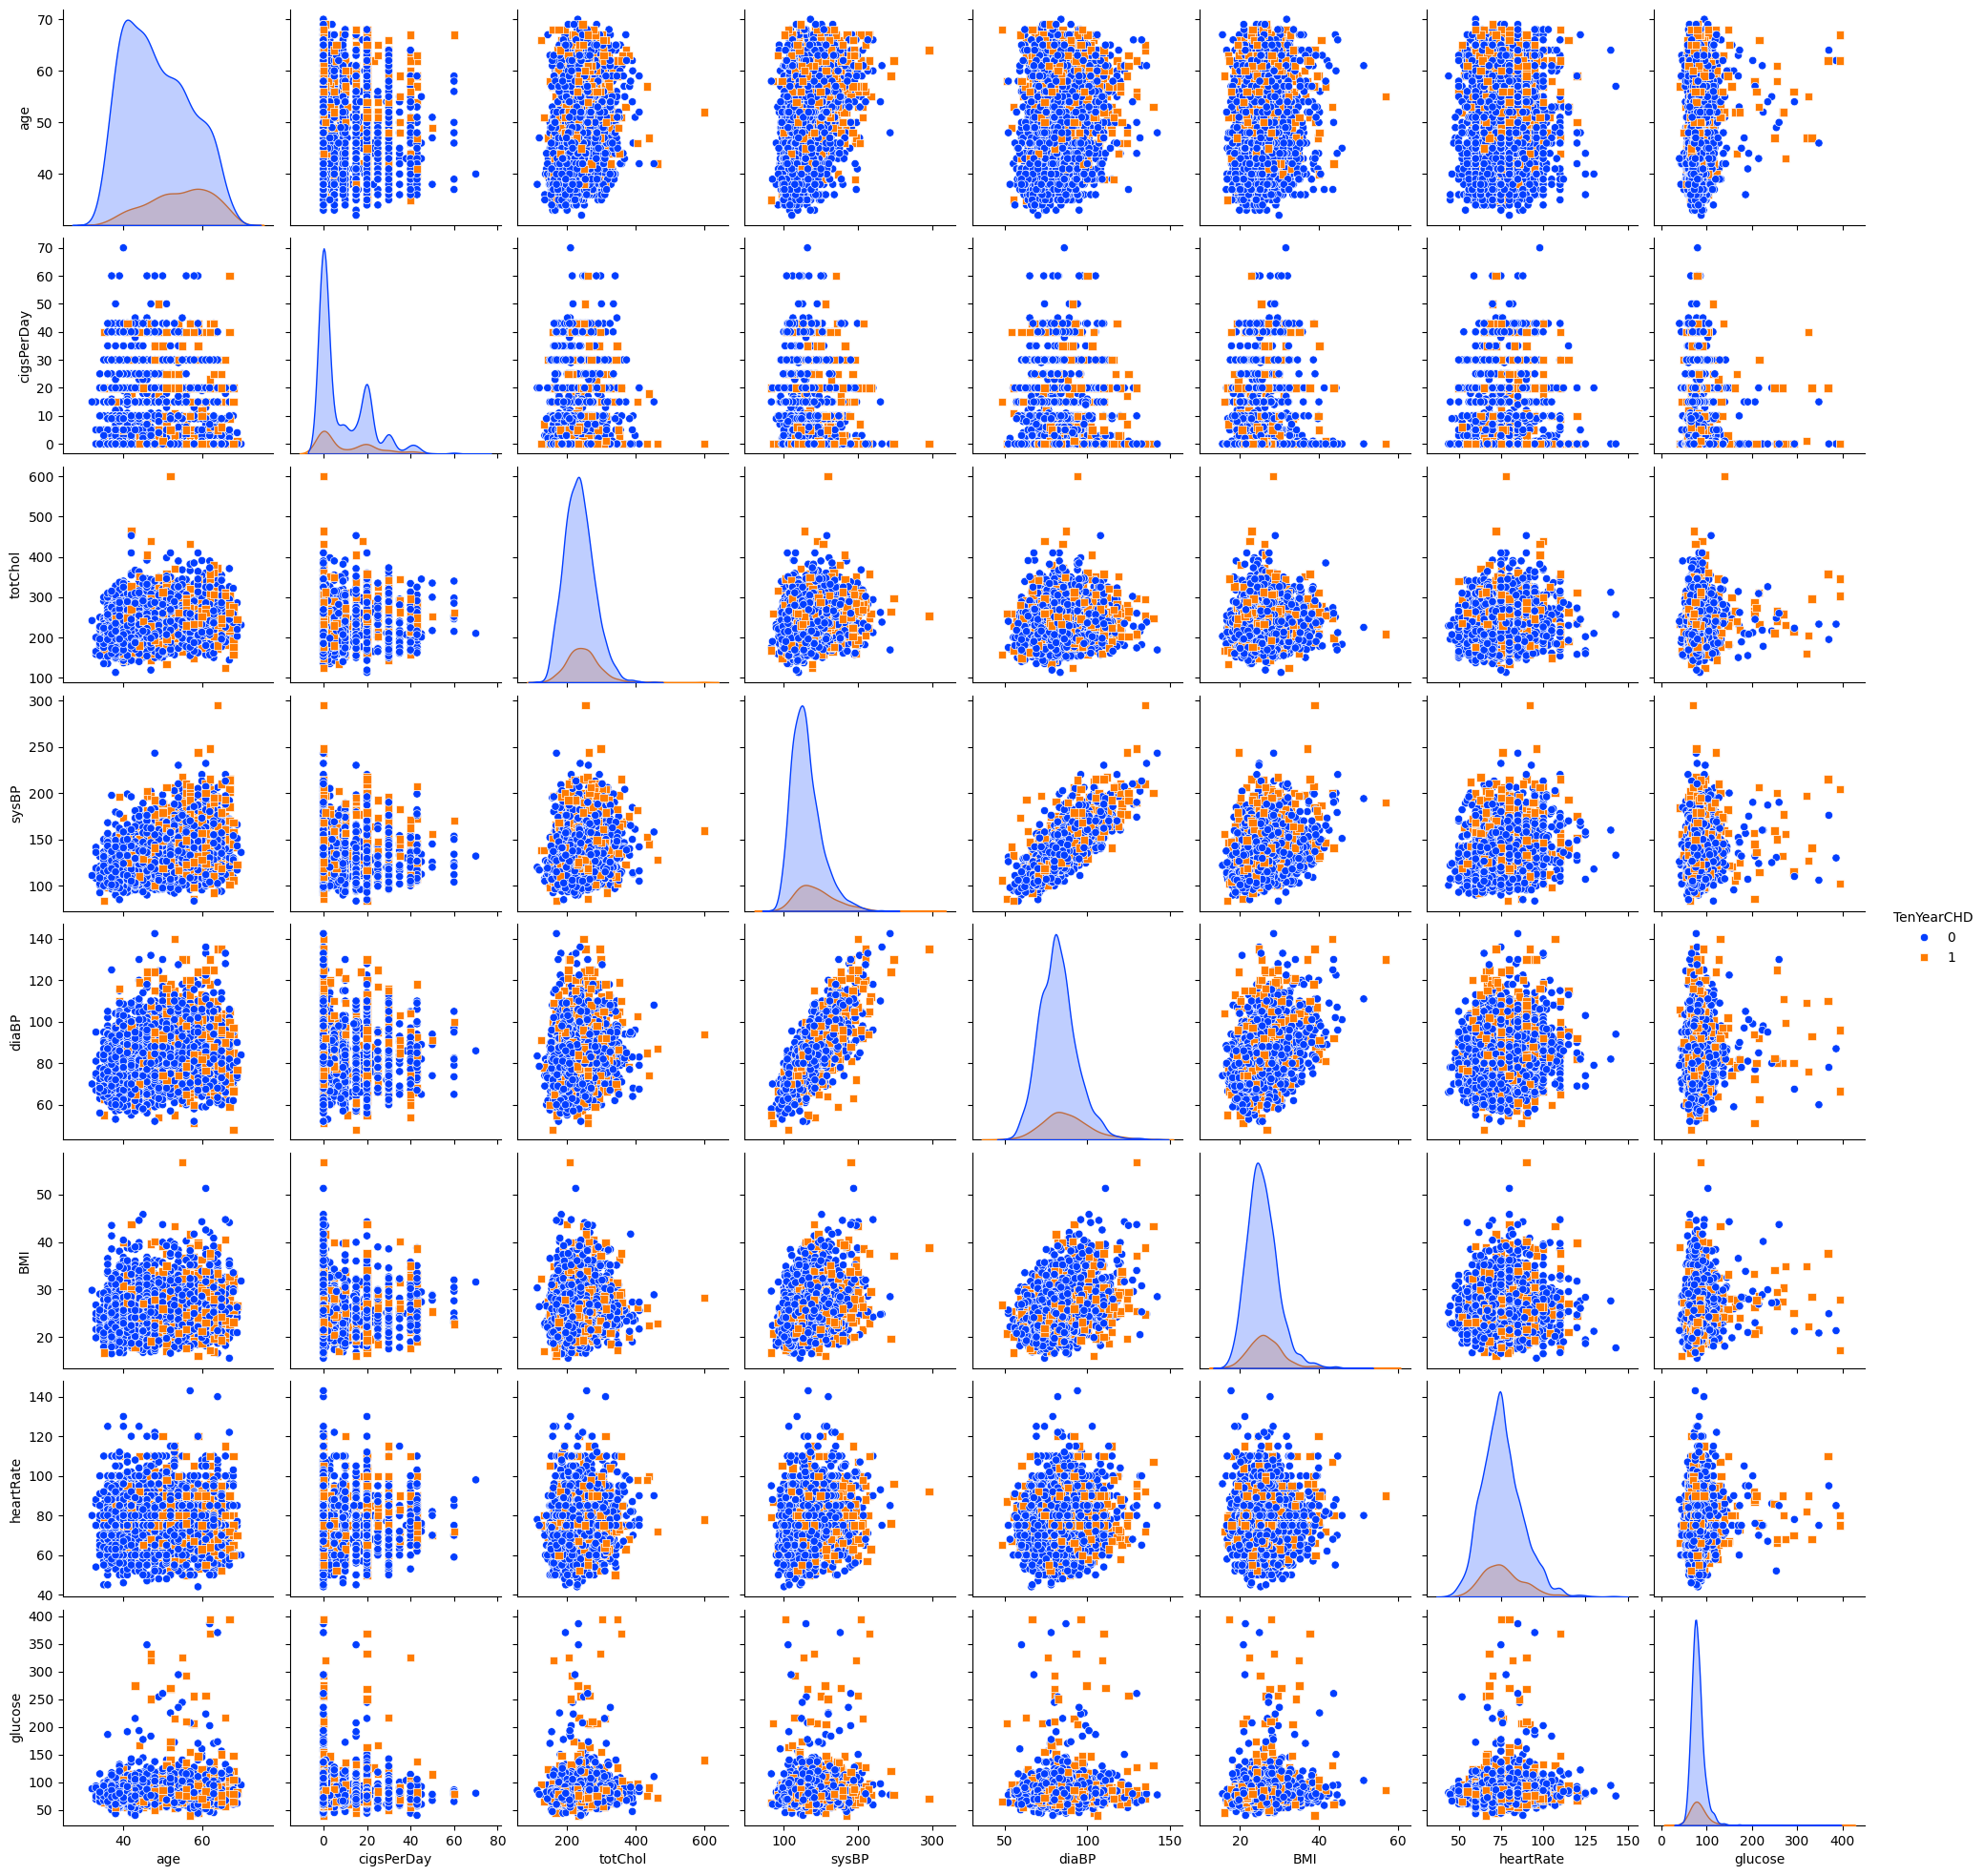

In [23]:
sns.pairplot(data, hue = 'TenYearCHD', markers=["o", "s"], vars = top_features, palette = sns.color_palette("bright", 10))

In [24]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from collections import Counter

In [25]:
X = data[top_features]
y = data.iloc[:,-1]

In [26]:
# the numbers before SMOTE
num_before = dict(Counter(y))

#perform SMOTE

# define pipeline
over = SMOTE(sampling_strategy=0.8)
under = RandomUnderSampler(sampling_strategy=0.8)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

# transform the dataset
X_smote, y_smote = pipeline.fit_resample(X, y)


#the numbers after SMOTE
num_after =dict(Counter(y_smote))

In [27]:
print(num_before, num_after)

{0: 3101, 1: 557} {0: 3100, 1: 2480}


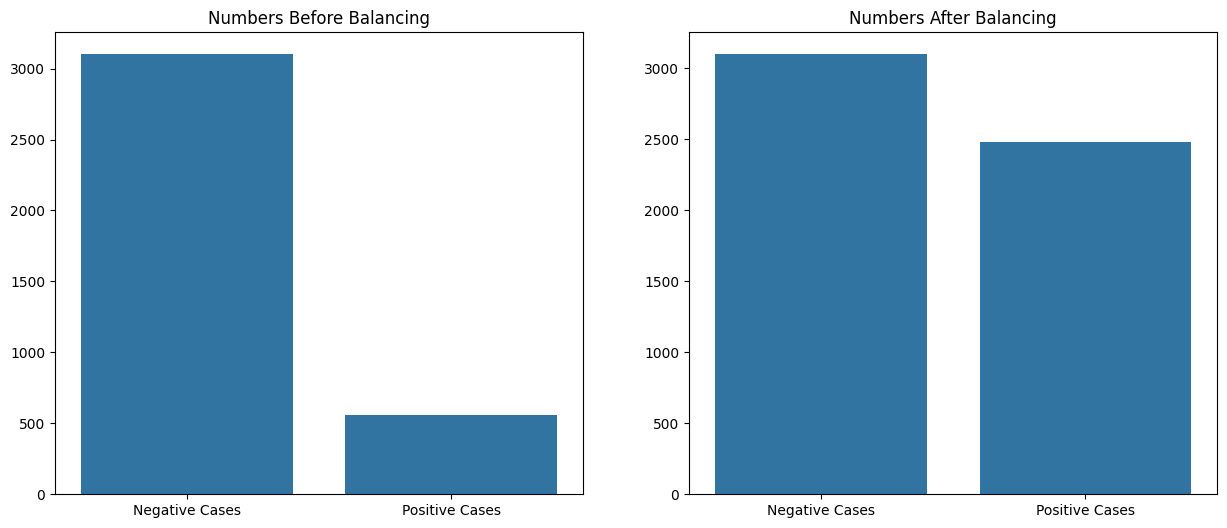

In [28]:
labels = ["Negative Cases","Positive Cases"]
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
sns.barplot(x=labels, y=list(num_before.values()))
plt.title("Numbers Before Balancing")
plt.subplot(1,2,2)
sns.barplot(x=labels, y=list(num_after.values()))
plt.title("Numbers After Balancing")
plt.show()

After applying SMOTE, the new dataset is much more balanced: the new ratio between negative and positive cases is 1:1.2 up from 1:5.57

## Splitting data to Training and Testing set

In [30]:
# new dataset
new_data = pd.concat([pd.DataFrame(X_smote), pd.DataFrame(y_smote)], axis=1)
new_data.columns = ['age', 'cigsPerDay', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose','TenYearCHD']
new_data.head()

,age,cigsPerDay,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
3461,45,30.0,233.0,147.0,101.0,24.32,75.0,99.0,0
1131,59,20.0,280.0,164.0,81.0,29.76,80.0,68.0,0
1208,63,20.0,252.0,149.0,90.0,33.49,82.0,83.0,0
648,52,0.0,196.0,126.0,80.0,22.32,104.0,74.0,0
3542,45,0.0,220.0,139.0,74.0,27.34,70.0,100.0,0


In [31]:
X_new = new_data[top_features]
y_new= new_data.iloc[:,-1]
X_new.head()

,age,cigsPerDay,totChol,sysBP,diaBP,BMI,heartRate,glucose
3461,45,30.0,233.0,147.0,101.0,24.32,75.0,99.0
1131,59,20.0,280.0,164.0,81.0,29.76,80.0,68.0
1208,63,20.0,252.0,149.0,90.0,33.49,82.0,83.0
648,52,0.0,196.0,126.0,80.0,22.32,104.0,74.0
3542,45,0.0,220.0,139.0,74.0,27.34,70.0,100.0


In [32]:
# split the dataset
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X_new,y_new,test_size=.2,random_state=42)

In [33]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train_scaled)

X_test_scaled = scaler.transform(X_test)
X_test = pd.DataFrame(X_test_scaled)

## Logistic regression

In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score,precision_score,classification_report,roc_auc_score,roc_curve

In [35]:
# search for optimun parameters using gridsearch
params = {'penalty':['l1','l2'],
         'C':[0.01,0.1,1,10,100],
         'class_weight':['balanced',None]}
logistic_clf = GridSearchCV(LogisticRegression(),param_grid=params,cv=10)

In [36]:
#train the classifier
logistic_clf.fit(X_train,y_train)

logistic_clf.best_params_

/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
100 fits failed out of a total of 200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
100 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py", line 1193, in fit
    solver = _check_sol

{'C': 0.01, 'class_weight': 'balanced', 'penalty': 'l2'}

In [37]:
#make predictions
logistic_predict = logistic_clf.predict(X_test)
log_accuracy = accuracy_score(y_test,logistic_predict)
print(f"Using logistic regression we get an accuracy of {round(log_accuracy*100,2)}%")

Using logistic regression we get an accuracy of 66.94%


<Axes: >

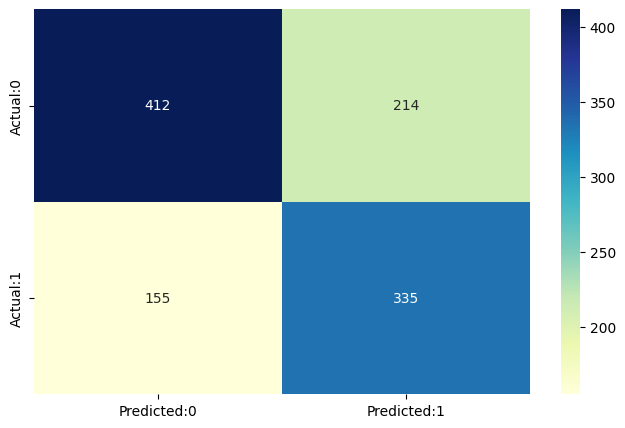

In [38]:
cm=confusion_matrix(y_test,logistic_predict)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu")

In [39]:
print(classification_report(y_test,logistic_predict))

              precision    recall  f1-score   support

           0       0.73      0.66      0.69       626
           1       0.61      0.68      0.64       490

    accuracy                           0.67      1116
   macro avg       0.67      0.67      0.67      1116
weighted avg       0.68      0.67      0.67      1116



In [40]:
logistic_f1 = f1_score(y_test, logistic_predict)
print(f'The f1 score for logistic regression is {round(logistic_f1*100,2)}%')

The f1 score for logistic regression is 64.49%


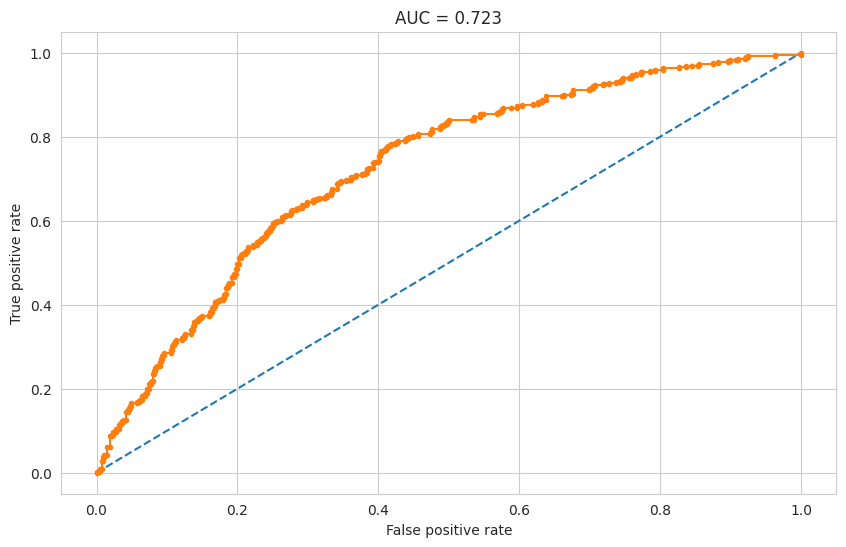

In [41]:
# ROC curve and AUC
probs = logistic_clf.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
log_auc = roc_auc_score(y_test, probs)

# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
# plot curve
sns.set_style('whitegrid')
plt.figure(figsize=(10,6))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.title(f"AUC = {round(log_auc,3)}")
plt.show()

## k-Nearest Neighbours

Using k-nearest neighbours we get an accuracy of 84.05%


<Axes: >

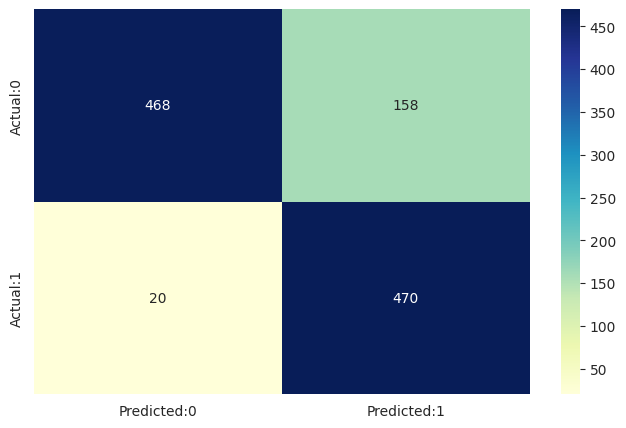

In [42]:
from sklearn.neighbors import KNeighborsClassifier
# search for optimun parameters using gridsearch
params= {'n_neighbors': np.arange(1, 10)}
grid_search = GridSearchCV(estimator = KNeighborsClassifier(), param_grid = params,
                           scoring = 'accuracy', cv = 10, n_jobs = -1)
knn_clf = GridSearchCV(KNeighborsClassifier(),params,cv=3, n_jobs=-1)
# train the model
knn_clf.fit(X_train,y_train)
knn_clf.best_params_
# predictions
knn_predict = knn_clf.predict(X_test)
#accuracy
knn_accuracy = accuracy_score(y_test,knn_predict)
print(f"Using k-nearest neighbours we get an accuracy of {round(knn_accuracy*100,2)}%")
cm=confusion_matrix(y_test,knn_predict)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu")

In [43]:
print(classification_report(y_test,knn_predict))

              precision    recall  f1-score   support

           0       0.96      0.75      0.84       626
           1       0.75      0.96      0.84       490

    accuracy                           0.84      1116
   macro avg       0.85      0.85      0.84      1116
weighted avg       0.87      0.84      0.84      1116



In [44]:
knn_f1 = f1_score(y_test, knn_predict)
print(f'The f1 score for K nearest neignbours is {round(knn_f1*100,2)}%')

The f1 score for K nearest neignbours is 84.08%


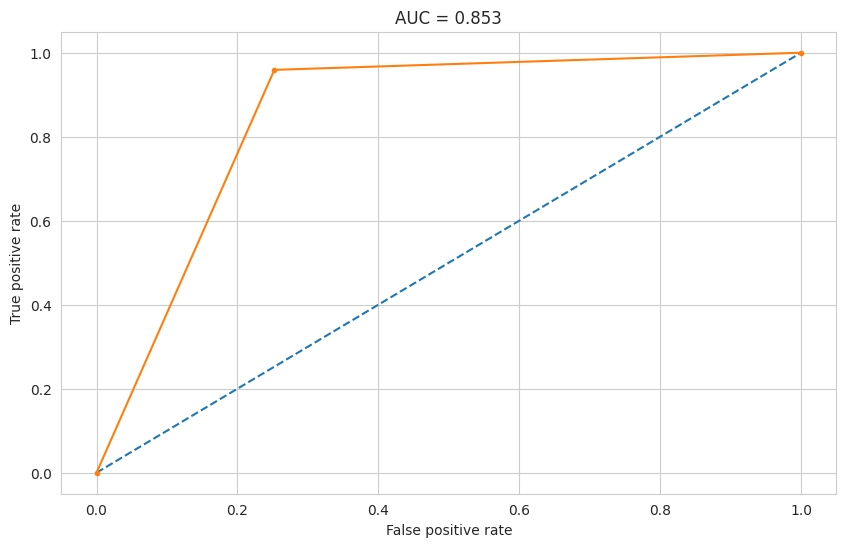

In [45]:
# ROC curve and AUC
probs = knn_clf.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
knn_auc = roc_auc_score(y_test, probs)

# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
# plot curve
sns.set_style('whitegrid')
plt.figure(figsize=(10,6))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.title(f"AUC = {round(knn_auc,3)}")
plt.show()

## Decision Trees

In [46]:
from sklearn.tree import DecisionTreeClassifier
dtree= DecisionTreeClassifier(random_state=7)
# grid search for optimum parameters
params = {'max_features': ['auto', 'sqrt', 'log2'],
          'min_samples_split': [2,3,4,5,6,7,8,9,10,11,12,13,14,15],
          'min_samples_leaf':[1,2,3,4,5,6,7,8,9,10,11]}
tree_clf = GridSearchCV(dtree, param_grid=params, n_jobs=-1)
# train the model
tree_clf.fit(X_train,y_train)
tree_clf.best_params_
# predictions
tree_predict = tree_clf.predict(X_test)
#accuracy
tree_accuracy = accuracy_score(y_test,tree_predict)
print(f"Using Decision Trees we get an accuracy of {round(tree_accuracy*100,2)}%")

Using Decision Trees we get an accuracy of 75.09%


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
770 fits failed out of a total of 2310.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
770 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.12/dist-packages/sklearn/uti

<Axes: >

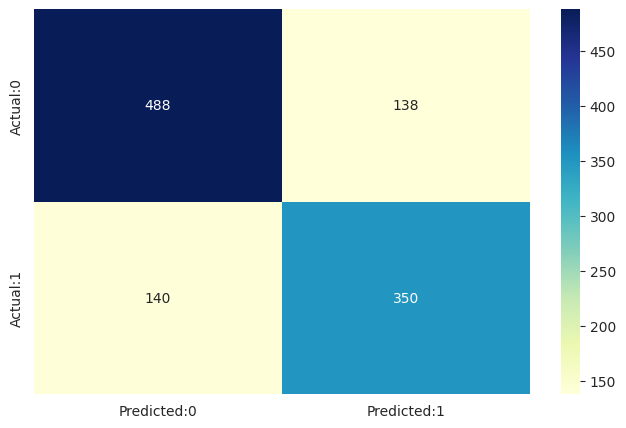

In [47]:
cm=confusion_matrix(y_test,tree_predict)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu")

In [48]:
print(classification_report(y_test,tree_predict))

              precision    recall  f1-score   support

           0       0.78      0.78      0.78       626
           1       0.72      0.71      0.72       490

    accuracy                           0.75      1116
   macro avg       0.75      0.75      0.75      1116
weighted avg       0.75      0.75      0.75      1116



In [49]:
tree_f1 = f1_score(y_test, tree_predict)
print(f'The f1 score Descision trees is {round(tree_f1*100,2)}%')

The f1 score Descision trees is 71.57%


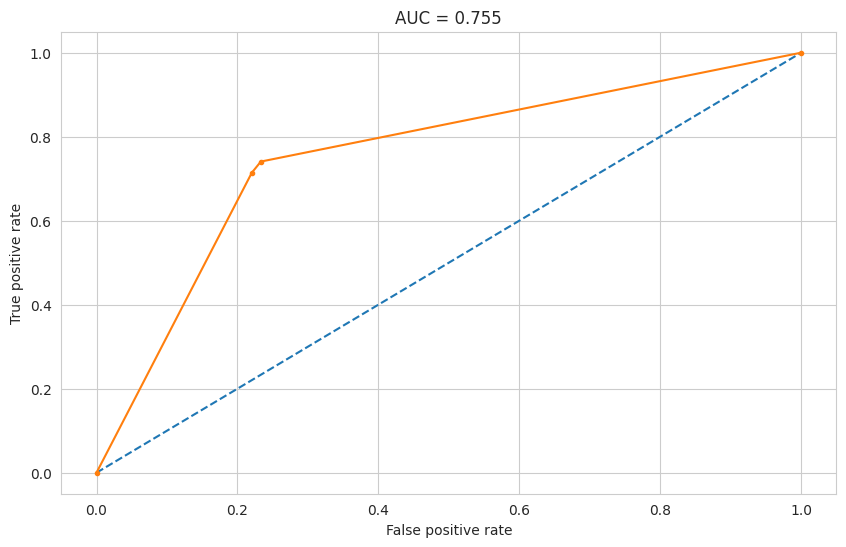

In [50]:
# ROC curve and AUC
probs = tree_clf.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
tree_auc = roc_auc_score(y_test, probs)

# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
# plot curve
sns.set_style('whitegrid')
plt.figure(figsize=(10,6))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.title(f"AUC = {round(tree_auc,3)}")
plt.show()

## Support Vector Machine

In [52]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV


In [53]:
#grid search for optimum parameters
Cs = [0.001, 0.01, 0.1, 1, 10]
gammas = [0.001, 0.01, 0.1, 1]
param_grid = {'C': Cs, 'gamma' : gammas}
svm_clf = GridSearchCV(SVC(kernel='rbf', probability=True), param_grid, cv=10)

In [55]:
# train the model
svm_clf.fit(X_train,y_train)
svm_clf.best_params_

{'C': 10, 'gamma': 1}

In [56]:
# predictions
svm_predict = svm_clf.predict(X_test)

In [57]:
#accuracy
svm_accuracy = accuracy_score(y_test,svm_predict)
print(f"Using SVM we get an accuracy of {round(svm_accuracy*100,2)}%")

Using SVM we get an accuracy of 87.72%


<Axes: >

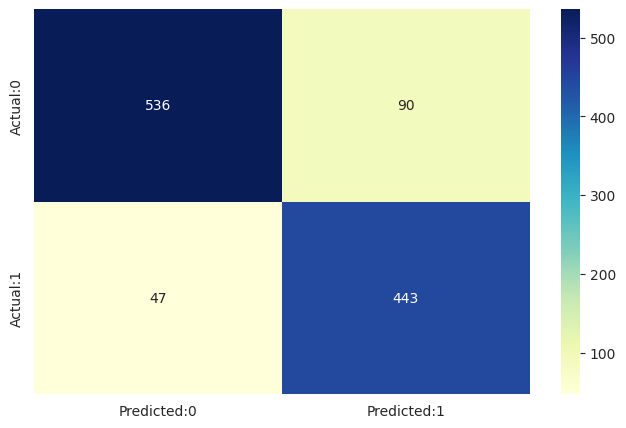

In [58]:
cm=confusion_matrix(y_test,svm_predict)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu")

In [59]:
print(classification_report(y_test,svm_predict))

              precision    recall  f1-score   support

           0       0.92      0.86      0.89       626
           1       0.83      0.90      0.87       490

    accuracy                           0.88      1116
   macro avg       0.88      0.88      0.88      1116
weighted avg       0.88      0.88      0.88      1116



In [60]:
svm_f1 = f1_score(y_test, svm_predict)
print(f'The f1 score for SVM is {round(svm_f1*100,2)}%')

The f1 score for SVM is 86.61%


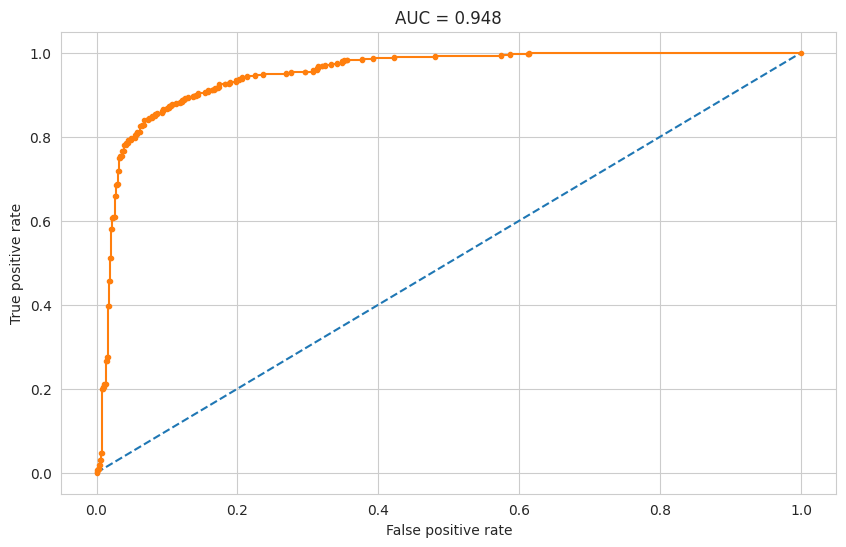

In [61]:
# ROC curve and AUC
probs = svm_clf.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
svm_auc = roc_auc_score(y_test, probs)

# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
# plot curve
sns.set_style('whitegrid')
plt.figure(figsize=(10,6))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.title(f"AUC = {round(svm_auc,3)}")
plt.show()

## Random Forest

In [65]:
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# --- Random Forest Classifier ---
rf_clf = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    class_weight='balanced',
    random_state=42
)
rf_clf.fit(X_train, y_train)
rf_pred = rf_clf.predict(X_test)

rf_accuracy = accuracy_score(y_test, rf_pred)
rf_f1 = f1_score(y_test, rf_pred)
print(f"Using Random Forest we get an accuracy of {round(rf_accuracy*100,2)}%")
print(f"The F1 score for Random Forest is {round(rf_f1*100,2)}%")

Using Random Forest we get an accuracy of 77.78%
The F1 score for Random Forest is 76.87%


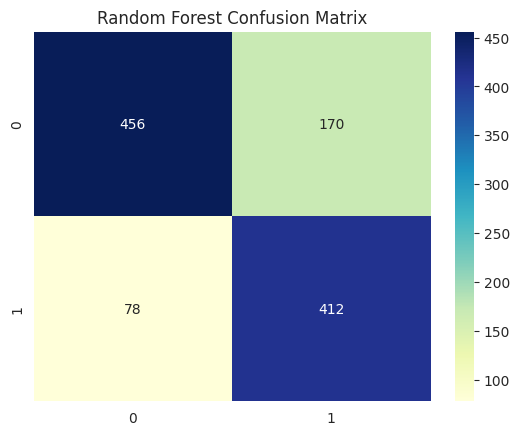

              precision    recall  f1-score   support

           0       0.85      0.73      0.79       626
           1       0.71      0.84      0.77       490

    accuracy                           0.78      1116
   macro avg       0.78      0.78      0.78      1116
weighted avg       0.79      0.78      0.78      1116



In [66]:
# Confusion Matrix
cm = confusion_matrix(y_test, rf_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu')
plt.title("Random Forest Confusion Matrix")
plt.show()

print(classification_report(y_test, rf_pred))

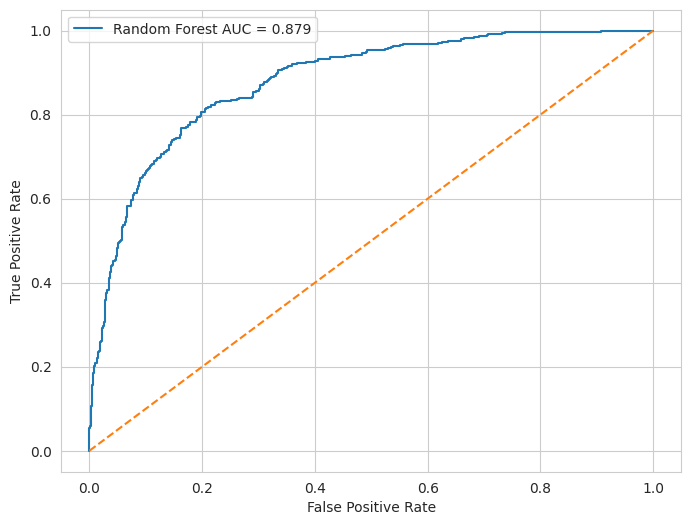

In [67]:
# ROC curve and AUC
rf_probs = rf_clf.predict_proba(X_test)[:, 1]
rf_auc = roc_auc_score(y_test, rf_probs)
fpr, tpr, _ = roc_curve(y_test, rf_probs)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f"Random Forest AUC = {round(rf_auc,3)}")
plt.plot([0,1],[0,1],'--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

## XGBoost Classifier

In [68]:
# --- XGBoost Classifier ---
xgb_clf = xgb.XGBClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='logloss'
)
xgb_clf.fit(X_train, y_train)
xgb_pred = xgb_clf.predict(X_test)

xgb_accuracy = accuracy_score(y_test, xgb_pred)
xgb_f1 = f1_score(y_test, xgb_pred)
print(f"Using XGBoost we get an accuracy of {round(xgb_accuracy*100,2)}%")
print(f"The F1 score for XGBoost is {round(xgb_f1*100,2)}%")

Using XGBoost we get an accuracy of 84.41%
The F1 score for XGBoost is 82.14%


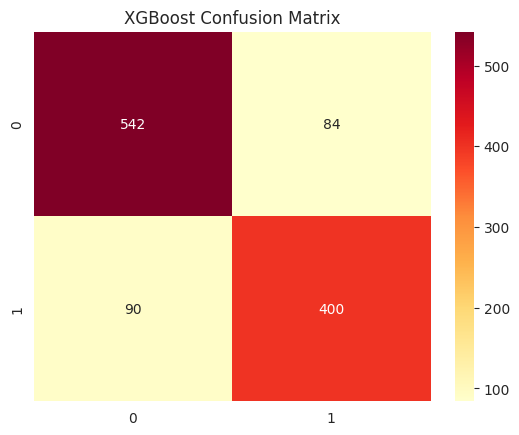

              precision    recall  f1-score   support

           0       0.86      0.87      0.86       626
           1       0.83      0.82      0.82       490

    accuracy                           0.84      1116
   macro avg       0.84      0.84      0.84      1116
weighted avg       0.84      0.84      0.84      1116



In [69]:
cm = confusion_matrix(y_test, xgb_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='YlOrRd')
plt.title("XGBoost Confusion Matrix")
plt.show()

print(classification_report(y_test, xgb_pred))

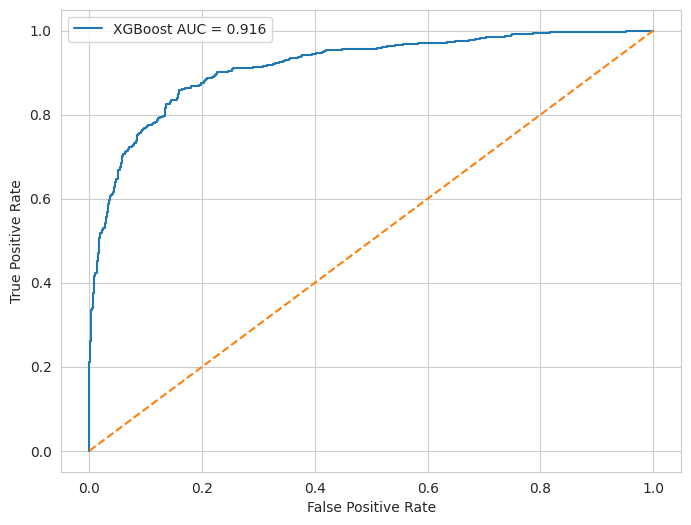

In [70]:
# ROC curve and AUC
xgb_probs = xgb_clf.predict_proba(X_test)[:, 1]
xgb_auc = roc_auc_score(y_test, xgb_probs)
fpr, tpr, _ = roc_curve(y_test, xgb_probs)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f"XGBoost AUC = {round(xgb_auc,3)}")
plt.plot([0,1],[0,1],'--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [71]:
comparison = pd.DataFrame({
    "Logistic regression":{'Accuracy':log_accuracy, 'AUC':log_auc, 'F1 score':logistic_f1},
    "K-nearest neighbours":{'Accuracy':knn_accuracy, 'AUC':knn_auc, 'F1 score':knn_f1},
    "Decision trees":{'Accuracy':tree_accuracy, 'AUC':tree_auc, 'F1 score':tree_f1},
    "Support vector machine":{'Accuracy':svm_accuracy, 'AUC':svm_auc, 'F1 score':svm_f1},
    "Random forest": {'Accuracy': rf_accuracy,'AUC': rf_auc, 'F1 score': rf_f1},
    "XGBoost": {'Accuracy': xgb_accuracy,'AUC': xgb_auc, 'F1 score': xgb_f1}
}).T
comparison

,Accuracy,AUC,F1 score
Logistic regression,0.669355,0.723365,0.644851
K-nearest neighbours,0.840502,0.853394,0.840787
Decision trees,0.750896,0.755435,0.715746
Support vector machine,0.877240,0.948376,0.866080
Random forest,0.777778,0.879145,0.768657
XGBoost,0.844086,0.915864,0.821355


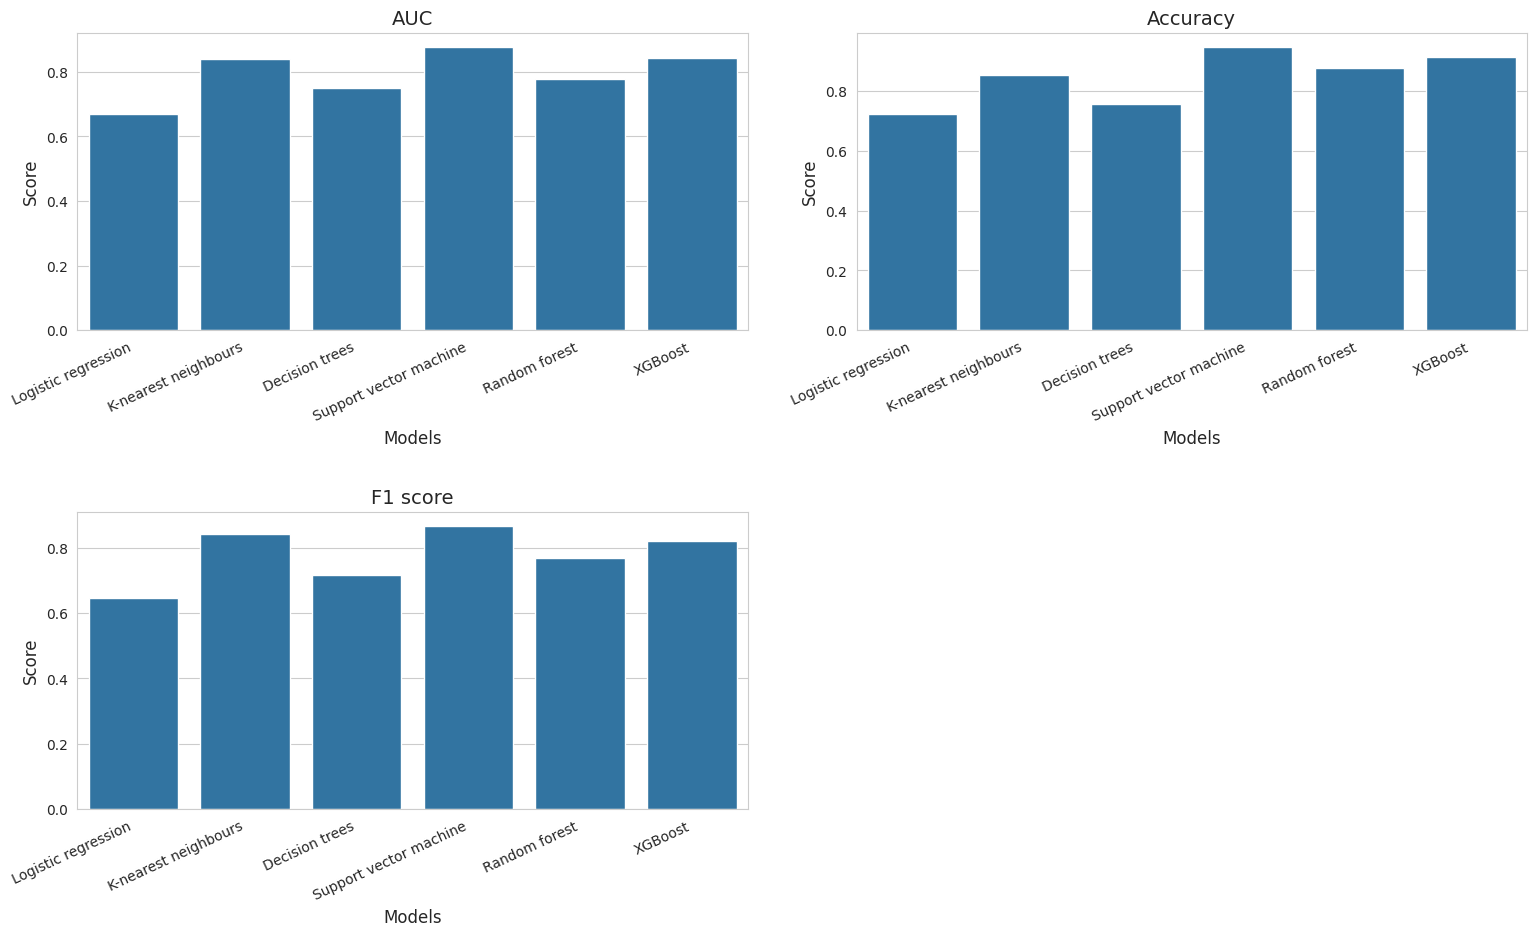

In [75]:
fig = plt.gcf()
fig.set_size_inches(16, 10)
titles = ['AUC', 'Accuracy', 'F1 score']

for i, label in enumerate(comparison.columns):
    plt.subplot(2, 2, i + 1)
    sns.barplot(x=comparison.index, y=comparison[label], data=comparison)
    plt.title(titles[i], fontsize=14)
    plt.ylabel('Score', fontsize=12)
    plt.xlabel('Models', fontsize=12)
    plt.xticks(rotation=25, ha='right', fontsize=10)  # rotate + align
    plt.tight_layout(pad=3.0)  # adds space between subplots

plt.show()
